# LSTM & Markov's chains

In [28]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import random
import pymorphy2
from collections import Counter

import tensorflow as tf

from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku
from keras.utils import np_utils

tf.random.set_seed(42)
np.random.seed(42)

import string, os 

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

## Dataset

Датасет я вытащил из лучших юморесок паблика "мои любимые юморески", так что должно быть постиронично.

In [2]:
with open('data/simplified.txt', 'r') as f:
    sentences = list(map(lambda s: s.strip(), f.readlines()))

In [3]:
sentences[:3]

['купил мужик шляпу а она ему как раз',
 'хохол проходит в армии комиссию кем хочешь служить хочу кинологом шоб с собаками работать ладно только смотри чтобы справился проходит 3 месяца комиссия прибыла в часть с проверкой встретили хохла ну давай показывай чего добился хохол выводит собаку и говорит микола ищи микола скрывается в кустах проходит 15 минут собака вся изодранная в репейнике и болотной жиже возвращается микола ну шо найшов микола кого',
 'идет пушкин по проселочной дороге догоняет его мужик на телеге ну пушкин ему и говорит подвези мужик до ближайшей деревни мужик говорит садитесь едут они едут ну и решил великий русский поэт удивить простого сельского мужика рифмой спрашивает мужик тебя как зовут иван о иван хуй тебе в карман отвечает пушкин мужик обиделся на поэта и говорит а тебя как зовут александр сергеевич говорит пушкин ну и слезай на хуй с телеги сидят в купе поезда два хохла пьют водку ведут разговоры на разные философские темы гриню ты ж взгляни на эту муху сидя

In [4]:
def get_vocab(sens):
    voc = Counter()
    for s in sens:
        for t in s:
            voc[t] += 1
    return voc, len(voc)

Добавим точку в конце каждого предложения:

In [5]:
sentences = list(map(lambda s: s.split() + ['.'], sentences))

In [6]:
sentences[0]

['купил', 'мужик', 'шляпу', 'а', 'она', 'ему', 'как', 'раз', '.']

In [7]:
get_vocab(sentences)[1]

15194

Я уже немного почистил датасет, но воспользуемся ещё и pymorhy, чтобы уменьшить количество слов:

In [8]:
morph = pymorphy2.MorphAnalyzer()
sentences = [[morph.parse(word)[0].normal_form for word in s] for s in sentences]

In [9]:
sentences[0]

['купить', 'мужик', 'шляпа', 'а', 'она', 'он', 'как', 'раз', '.']

Уже постиронично получается.

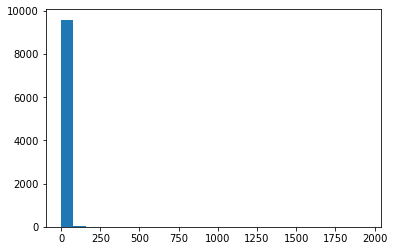

In [10]:
vocab, counts = get_vocab(sentences)

freq = vocab.values()

plt.hist(freq, bins=25)
plt.show()

In [11]:
vocab.most_common(10)

[('и', 1943),
 ('в', 1583),
 ('я', 1295),
 ('на', 1018),
 ('а', 967),
 ('не', 861),
 ('что', 858),
 ('он', 818),
 ('ты', 813),
 ('с', 596)]

Забавно, что точка не попала в список самых частых слов, даже в топ-10. Ну, анекдотов у нас немного, а точку я добавил только как фулл-стоп.

## Markov Chains

In [12]:
class MarkovChain:   
    def __init__(self, n=2):
        self.n = n
        self.pr = {}
        
    def fit(self, sequences):
        for sentence in sequences:
            for i in range(self.n, len(sentence)):
                prev = tuple(sentence[i - self.n:i])
                cur = sentence[i]
                if cur not in self.pr:
                    self.pr[cur] = {}
                if prev not in self.pr[cur]:
                    self.pr[cur][prev] = 0
                self.pr[cur][prev] += 1
                
    def cnt_word_given_sen(self, word, sentence):
        return self.pr.get(word, {}).get(sentence, 0)
                
    def predict_max(self, sentence):
        sentence = tuple(sentence[-self.n:])
        words_cnts = [(word, self.cnt_word_given_sen(word, sentence)) for word in self.pr.keys()]
        words_cnts.sort(key=lambda x: -x[1])
        words_cnts = list(filter(lambda x: x[1] == words_cnts[0][1], words_cnts))
        return random.choice([w[0] for w in words_cnts])
    
    def predict_rand(self, sentence):
        sentence = tuple(sentence[-self.n:])
        words = np.array([(w, self.cnt_word_given_sen(w, sentence)) for w in self.pr.keys()])
        prs = words[:, 1].astype('float')
        if max(prs) == 0:
            return random.choice(words[:, 0])
        else:
            words = words[prs > 0]
            prs = words[:, 1].astype('float')
            prs /= sum(prs)
            return np.random.choice(words[:, 0], p=prs)

In [13]:
def generate_seq(tail, model, max_size: int = 100, rand: bool = True):
    i = 0
    while tail[-1] != '.' and i < max_size:
        c = model.predict_rand(tail) if rand else model.predict_max(tail)
        tail.append(c)
        i += 1
    return ' '.join(tail)

def from_start(start: str, model, samples: int = 10, max_size: int = 100, rand: bool = True):
    seq = start.split()
    return [generate_seq(seq, model, max_size, rand) for _ in range(samples)]

In [14]:
model = MarkovChain(n=1)
model.fit(sentences)

In [15]:
print('\n\n\n'.join(from_start('купить мужик шляпа', model, samples=5, max_size=10)))

купить мужик шляпа полный ведро вытаскиваться и говорить я ты ебало дать ты


купить мужик шляпа полный ведро вытаскиваться и говорить я ты ебало дать ты висеть прямо из за угол врач сказать строчка нет вы


купить мужик шляпа полный ведро вытаскиваться и говорить я ты ебало дать ты висеть прямо из за угол врач сказать строчка нет вы измерять она падать на земля и никак даже превосходящий сила


купить мужик шляпа полный ведро вытаскиваться и говорить я ты ебало дать ты висеть прямо из за угол врач сказать строчка нет вы измерять она падать на земля и никак даже превосходящий сила бить яйцо ты че это похоже у мы ночью оступиться


купить мужик шляпа полный ведро вытаскиваться и говорить я ты ебало дать ты висеть прямо из за угол врач сказать строчка нет вы измерять она падать на земля и никак даже превосходящий сила бить яйцо ты че это похоже у мы ночью оступиться и он сегодня в очко сказать главный разработчик ну бл@


Мда, такое себе

Попробуем смотреть на больше слов назад!

In [16]:
model_back = MarkovChain(n=3)
model_back.fit(sentences)

In [17]:
print('\n\n\n'.join(from_start('купить мужик шляпа', model_back, samples=5, max_size=10)))

купить мужик шляпа выйти из магазин и направиться к вокзал где скоро должный


купить мужик шляпа выйти из магазин и направиться к вокзал где скоро должный быть подойти он электропоезд быть чудный летний денёк всё вокруг


купить мужик шляпа выйти из магазин и направиться к вокзал где скоро должный быть подойти он электропоезд быть чудный летний денёк всё вокруг благоухать а человек оглядываться мужик вослед казаться сам вселенная сегодня


купить мужик шляпа выйти из магазин и направиться к вокзал где скоро должный быть подойти он электропоезд быть чудный летний денёк всё вокруг благоухать а человек оглядываться мужик вослед казаться сам вселенная сегодня играть на он сторона злой бродячий пёс почтительно уступать он


купить мужик шляпа выйти из магазин и направиться к вокзал где скоро должный быть подойти он электропоезд быть чудный летний денёк всё вокруг благоухать а человек оглядываться мужик вослед казаться сам вселенная сегодня играть на он сторона злой бродячий пёс почтительно

Ну хотя бы анекдот был рассказан правильно.

In [18]:
model_back = MarkovChain(n=2)
model_back.fit(sentences)

In [19]:
print('\n\n\n'.join(from_start('купить мужик шляпа', model_back, samples=5, max_size=10)))

купить мужик шляпа выйти из крошшер открыть задний дверь а там петух валяться


купить мужик шляпа выйти из крошшер открыть задний дверь а там петух валяться дохлый в лужа наступить он платок достать ботиночек она протереть


купить мужик шляпа выйти из крошшер открыть задний дверь а там петух валяться дохлый в лужа наступить он платок достать ботиночек она протереть кавалер друг рассказать свой друг тот следующум и так далее


купить мужик шляпа выйти из крошшер открыть задний дверь а там петух валяться дохлый в лужа наступить он платок достать ботиночек она протереть кавалер друг рассказать свой друг тот следующум и так далее но мой сладенький в бар первый заказывать один пиво второй


купить мужик шляпа выйти из крошшер открыть задний дверь а там петух валяться дохлый в лужа наступить он платок достать ботиночек она протереть кавалер друг рассказать свой друг тот следующум и так далее но мой сладенький в бар первый заказывать один пиво второй половина кружка третий четверть бармен о

Вот это золото!

## LSTM

In [27]:
tokenizer = Tokenizer()
max_sequence_len = 5
stride = 1
vocab, vlen = get_vocab(sentences)
tabu_words = set()
for k, v in vocab.items():
    if v == 1:
        tabu_words.add(k)
        
sequences = []
for line in sentences:
    for i in range(0, len(line) - max_sequence_len - 1, stride):
        cur_seq = line[i:i+max_sequence_len + 1]
        if all(w not in tabu_words for w in cur_seq):
            sequences.append(cur_seq)

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(0, len(token_list) - max_sequence_len, stride):
            n_gram_sequence = token_list[i:i+max_sequence_len]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

corpus = [' '.join(s) for s in sequences]
inp_sequences, total_words = get_sequence_of_tokens(corpus)
print(f'# of seqs = {len(inp_sequences)}, total_words = {total_words}')

# of seqs = 36478, total_words = 4342


In [22]:
def generate_padded_sequences(input_sequences):
    input_sequences = np.array(input_sequences)
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.np_utils.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

In [23]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(LSTM(200))
    model.add(Dropout(0.2))
    
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

2022-05-25 15:30:07.407298: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-25 15:30:07.407317: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-25 15:30:07.407333: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (covariance-ThinkPad-X280): /proc/driver/nvidia/version does not exist
2022-05-25 15:30:07.407504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 10)             43420     
                                                                 
 lstm (LSTM)                 (None, 200)               168800    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 4342)              872742    
                                                                 
Total params: 1,084,962
Trainable params: 1,084,962
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(predictors, label, epochs=200, verbose=0)

2022-05-25 15:30:07.670457: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 633549904 exceeds 10% of free system memory.


In [25]:
def generate_text(seed_text, next_words, model):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = ku.pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predict_x=model.predict(token_list).squeeze()
        predicted=np.random.choice(range(len(predict_x)), p=predict_x)
        
        output_word = ''
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += ' ' + output_word
    return seed_text

In [26]:
for i in range(10):
    print(generate_text('купить мужик шляпа', 20, model))

1/1 [==============================] - 0s 16ms/step
купить мужик шляпа кровать дом на магазин тут в кресло секунда на школа вы лежать себя не быть в раз помочь когда кровь
1/1 [==============================] - 0s 18ms/step
купить мужик шляпа кровать а на дом ты зеркало мальчик ебать а ну а знать а жена заходить да и в белый понимать
1/1 [==============================] - 0s 17ms/step
купить мужик шляпа жена она в штаны не получиться ты я ждать не сорок успех да теперь на машина кто знать и делать
1/1 [==============================] - 0s 17ms/step
купить мужик шляпа кровать она он и кровать он что отец я начинать доллар она я здравствуй обосраться он я новый умереть и
1/1 [==============================] - 0s 17ms/step
купить мужик шляпа кровать из магазин и хорошо себя стул она ещё вы она актёр у мы они быть в конец в очередь
1/1 [==============================] - 0s 19ms/step
купить мужик шляпа жена она он два машинка за три рука и а что то девушка среди вы поднять проблема на свой 

Отстой честно говоря...